In [26]:
import os
import sys
import rootpath
sys.path.append(rootpath.detect())
import pickle
from testsuite.utilities import Pareto_split
import numpy as np
from testsuite.analysis import load_all, plot_all_pareto_2d, PLOT_STYLE, plot_measure
import matplotlib.pyplot as plt

In [27]:
dir_path = os.getcwd()
result_dirs = sorted(os.listdir("./log_data/"))
result_dirs

['test_function_Saf_Sms_init10_MultiSurrogate_mean',
 'test_function_Saf_init10_MultiSurrogate_ei',
 'test_function_Saf_init10_MultiSurrogate_mean',
 'test_function_SmsEgo_init10_MultiSurrogate_ei',
 'test_function_Sms_Saf_init10_MultiSurrogate_mean']

In [28]:
try: 
    safsms_results = pickle.load(open("./pkl_data/safsms_results.pkl", "rb"))
    saf_ei_results = pickle.load(open("./pkl_data/saf_ei_results.pkl", "rb"))
    saf_mu_results = pickle.load(open("./pkl_data/saf_mu_results.pkl", "rb"))
    sms_ei_results = pickle.load(open("./pkl_data/sms_ei_results.pkl", "rb"))
    sms_mu_results = pickle.load(open("./pkl_data/sms_mu_results.pkl", "rb"))
except FileNotFoundError:
    print("Pickle files not loaded")
    safsms_results = load_all(os.path.join(dir_path, "log_data/", result_dirs[0]))
    saf_ei_results = load_all(os.path.join(dir_path, "log_data/", result_dirs[1]))
    saf_mu_results = load_all(os.path.join(dir_path, "log_data/", result_dirs[2]))
    sms_ei_results = load_all(os.path.join(dir_path, "log_data/", result_dirs[3]))
    sms_mu_results = load_all(os.path.join(dir_path, "log_data/", result_dirs[4]))

Pickle files not loaded


In [29]:
results = [safsms_results,
           saf_ei_results,
           saf_mu_results,
           sms_ei_results,
           sms_mu_results]


names = ["safsms_results",
         "saf_ei_results",
         "saf_mu_results",
         "sms_ei_results",
         "sms_mu_results"]

for result in results:
    assert(len(result["y"]) == len(results[0]["y"]))

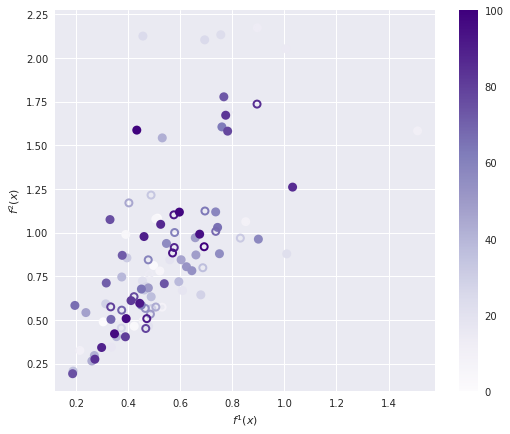

In [30]:
fig_smsmu = plot_all_pareto_2d(sms_mu_results, plot_indices=[0])

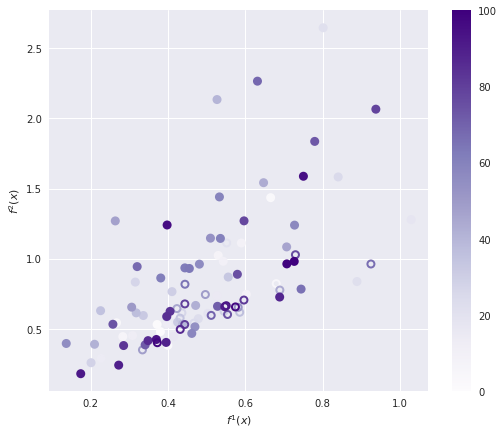

In [31]:
fig_smsmei= plot_all_pareto_2d(sms_ei_results, plot_indices=[0])

In [33]:
import wfg
N= 500

n_obj = 5                                   # Number of objectives
kfactor = 2
lfactor = 2

k = kfactor*(n_obj-1)   # position related params
l = lfactor*2           # distance related params
n_dim = k+l

func = wfg.WFG4

x_limits = np.zeros((2, n_dim))
x_limits[1] = np.array(range(1,n_dim+1))*2


args = [k, n_obj] # number of objectives as argument

y = np.zeros((N, n_obj))
for n in range(N):
    z = wfg.random_soln(k, l, func.__name__)
    y[n,:] = func(z, k, n_obj)

In [38]:
from pymoo.factory import get_performance_indicator

In [39]:
def extract_performance(z, indicator):
    ANS  = []
    for i in range(9, len(z)):
        p = Pareto_split(z[:i])[0]
        ans = indicator.calc(p)
        ANS.append(ans)

    return ANS

In [40]:
import lhsmdu
lhs_x =np.array(lhsmdu.sample(numDimensions=n_dim, numSamples=100)).T*x_limits[1]
lhs_y = np.array([func(z, k, n_obj) for z in lhs_x])

In [41]:
ref = lhs_y.max(axis=0)
ref

array([ 1.15106293,  1.75690465,  4.63551844,  7.12001168, 10.4679804 ])

In [42]:
igdp = get_performance_indicator("igd+", y)
hv = get_performance_indicator("hv", ref_point=ref)

In [43]:
lhslhs_results = {"y": lhs_y,
                 "x": lhs_x}

lhslhs_results["n_initial"] = safsms_results['n_initial'][0]
lhslhs_results["hypervolume"] = hv.calc(lhslhs_results["y"])
lhslhs_results["igd"] = igdp.calc(lhslhs_results["y"])

print(lhslhs_results['hypervolume'])
print(lhslhs_results['igd'])
print(lhslhs_results['n_initial'])

ref_hv = hv.calc(np.zeros_like(ref))
print(ref_hv)

70.95242544286184
0.7077697419748565
10
698.6974848777081


In [44]:
safsms_results['igd'] = [extract_performance(safsms_results["y"][i], igdp) for i in range(len(safsms_results["y"]))]
saf_ei_results['igd'] = [extract_performance(saf_ei_results["y"][i], igdp) for i in range(len(saf_ei_results["y"]))]
saf_mu_results['igd'] = [extract_performance(saf_mu_results["y"][i], igdp) for i in range(len(saf_mu_results["y"]))]
sms_ei_results['igd'] = [extract_performance(sms_ei_results["y"][i], igdp) for i in range(len(sms_ei_results["y"]))]
sms_mu_results['igd'] = [extract_performance(sms_mu_results["y"][i], igdp) for i in range(len(sms_mu_results["y"]))]

In [45]:
safsms_results['hypervolume'] = [extract_performance(safsms_results["y"][i], hv)/ref_hv for i in range(len(safsms_results["y"]))]
saf_ei_results['hypervolume'] = [extract_performance(saf_ei_results["y"][i], hv)/ref_hv for i in range(len(saf_ei_results["y"]))]
saf_mu_results['hypervolume'] = [extract_performance(saf_mu_results["y"][i], hv)/ref_hv for i in range(len(saf_mu_results["y"]))]
sms_ei_results['hypervolume'] = [extract_performance(sms_ei_results["y"][i], hv)/ref_hv for i in range(len(sms_ei_results["y"]))]
sms_mu_results['hypervolume'] = [extract_performance(sms_mu_results["y"][i], hv)/ref_hv for i in range(len(sms_mu_results["y"]))]

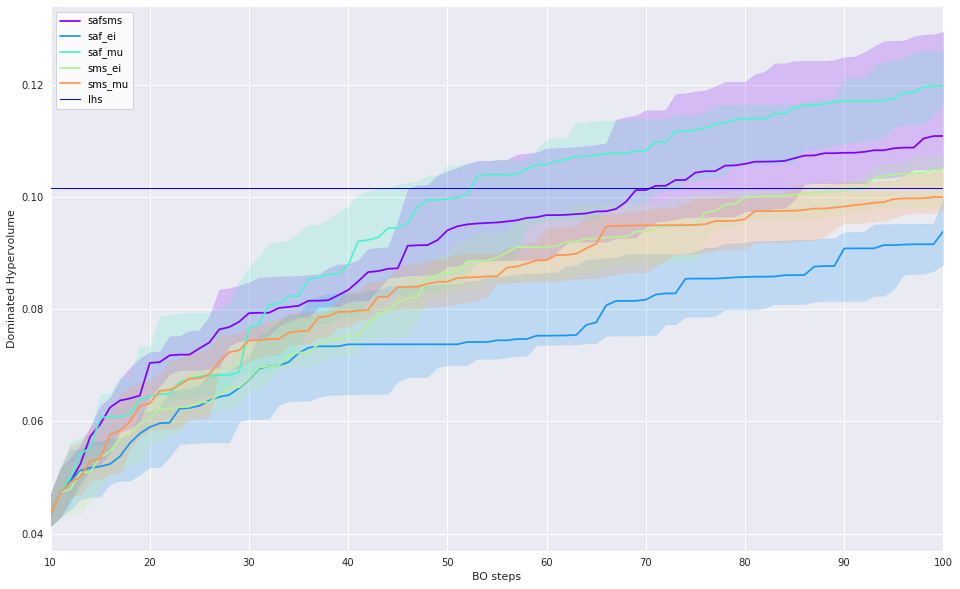

In [50]:
with plt.style.context(PLOT_STYLE["plot_style"]):
    fig_hv = plt.figure(figsize=[16, 10])
    ax_hv = fig_hv.gca()

cmap = PLOT_STYLE['plot_cmap']
colors = cmap(np.linspace(0, 1, len(result_dirs)+1))

plot_measure(safsms_results, measure="hypervolume", axis=ax_hv, plot_individuals=False, label="safsms", color=colors[0])
plot_measure(saf_ei_results, measure="hypervolume", axis=ax_hv, plot_individuals=False, label="saf_ei", color=colors[1])
plot_measure(saf_mu_results, measure="hypervolume", axis=ax_hv, plot_individuals=False, label="saf_mu", color=colors[2])
plot_measure(sms_ei_results, measure="hypervolume", axis=ax_hv, plot_individuals=False, label="sms_ei", color=colors[3])
plot_measure(sms_mu_results, measure="hypervolume", axis=ax_hv, plot_individuals=False, label="sms_mu", color=colors[4])
ax_hv.axhline(lhslhs_results["hypervolume"]/ref_hv, linewidth=1, color="b", label="lhs")
# ax_hv.plot(range(10,101), q_result["hypervolume"], linewidth=1, color="r", label="q")
ax_hv.set_xlim([10, 100])
ax_hv.set_xlabel("BO steps")
ax_hv.set_ylabel("Dominated Hypervolume")
ax_hv.legend()

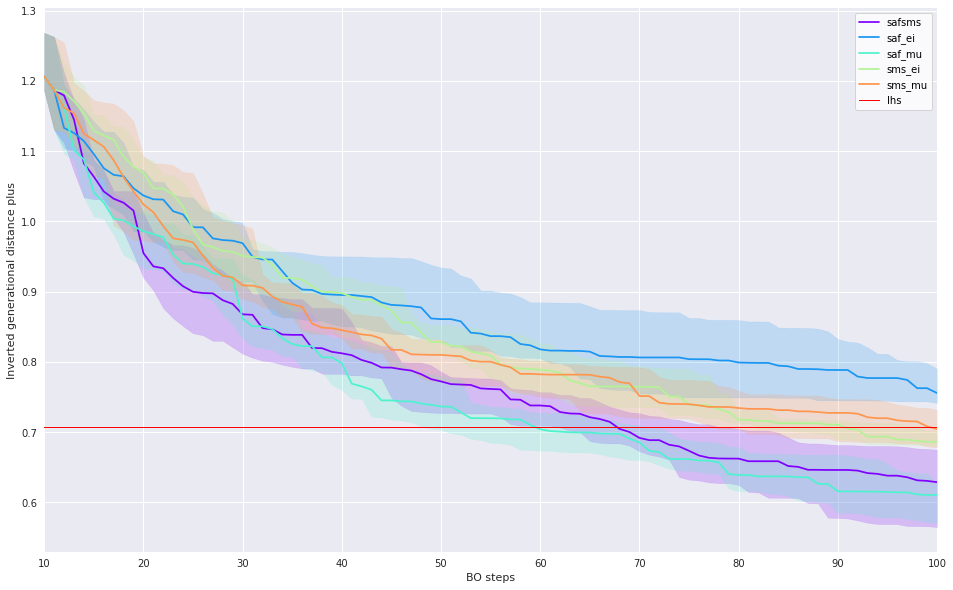

In [47]:
with plt.style.context(PLOT_STYLE["plot_style"]):
    fig_hv = plt.figure(figsize=[16, 10])
    ax_hv = fig_hv.gca()

cmap = PLOT_STYLE['plot_cmap']
colors = cmap(np.linspace(0, 1, len(result_dirs)+1))

plot_measure(safsms_results, measure="igd", axis=ax_hv, plot_individuals=False, label="safsms", color=colors[0])
plot_measure(saf_ei_results, measure="igd", axis=ax_hv, plot_individuals=False, label="saf_ei", color=colors[1])
plot_measure(saf_mu_results, measure="igd", axis=ax_hv, plot_individuals=False, label="saf_mu", color=colors[2])
plot_measure(sms_ei_results, measure="igd", axis=ax_hv, plot_individuals=False, label="sms_ei", color=colors[3])
plot_measure(sms_mu_results, measure="igd", axis=ax_hv, plot_individuals=False, label="sms_mu", color=colors[4])
ax_hv.axhline(lhslhs_results["igd"], linewidth=1, color="r", label="lhs")
# ax_hv.axhline(lhslhs_results["igd"][0], xmin=10, xmax=100, c=colors[7], label="lhs")

ax_hv.set_xlim([10, 100])
ax_hv.set_xlabel("BO steps")
ax_hv.set_ylabel("Inverted generational distance plus")
ax_hv.legend()

In [48]:
[result["errors"] for result in results]

[[[], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], []]]

In [49]:
try:
    for result, name in zip(results, names):
        pickle.dump(result, open("./pkl_data/"+name+".pkl", "wb"))
except FileNotFoundError:
    os.mkdir("./pkl_data")
    for result, name in zip(results, names):
        pickle.dump(result, open("./pkl_data/"+name+".pkl", "wb"))